<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Hochschule-esslingen.svg/320px-Hochschule-esslingen.svg.png" />

<br>Name: Panagiotis Theofanidis, 761737
<br>Team Name: EZ3DML
<br>Studiengang: SWB
<br>E-mail: pathit01@hs-esslingen.de

<br>Lecture: Applied Artificial Intelligence
<br>Semseter: SS2023
<br>Lecturers: Dionysios Satikidis (dionysios.satikidis@gmail.com); Jan Seyler (jan.seyler@gmail.com)


***

## Import


In [1]:
# Set our working directory based on whether we are in Google Colab or not
BASE_DIR = "./"
if "google.colab" in str(get_ipython()):
    BASE_DIR = '/content/drive/MyDrive/colab/aai/'
    !pip3 install trimesh


In [2]:
import os
import trimesh
from pathlib import Path
from matplotlib import pyplot as plt
from IPython.display import clear_output

import torch
from torch.utils.data import DataLoader, Dataset

if torch.cuda.is_available():
    torch.set_default_device('cuda')
    torch.multiprocessing.set_start_method('spawn')
    torch.set_float32_matmul_precision('high')
    print(torch.cuda.get_device_properties(torch.cuda.current_device()))


_CudaDeviceProperties(name='AMD Radeon RX 7900 XTX', major=11, minor=0, gcnArchName='gfx1100', total_memory=24560MB, multi_processor_count=48)


In [3]:
DATA_DIR = os.path.join(BASE_DIR, 'data')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

if not os.path.exists(DATA_DIR):
    raise Exception('Data directory not found. Have you run the data generation notebook?')


# Data

In [4]:
class PointCloudDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.files = list(Path(root_dir).glob('*.ply'))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        point_cloud = trimesh.load(self.files[idx])
        if not isinstance(point_cloud, trimesh.PointCloud):
            raise ValueError(f"Tried to load {self.files[idx]} but it is not a point cloud!")

        return torch.tensor(point_cloud.vertices, dtype=torch.float32)


Batch shape: torch.Size([2, 2048, 3])
Batch type: torch.float32
Batch device: cuda:0
Train sample:


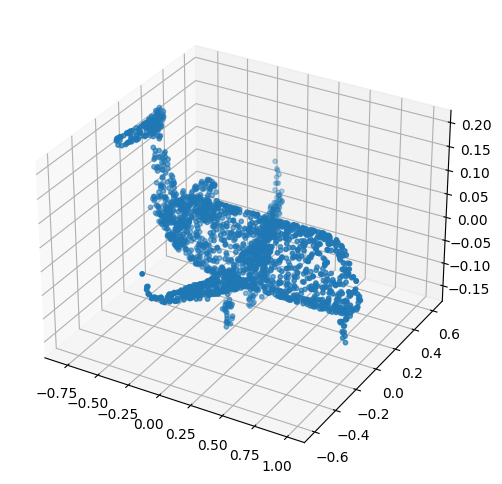

Validation sample:


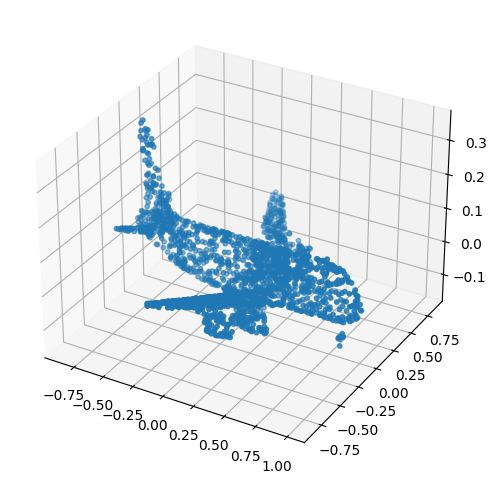

In [5]:
# Dataset and dataloader
train_dataset = PointCloudDataset(TRAIN_DIR)
val_dataset = PointCloudDataset(VAL_DIR)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                              generator=torch.Generator(device=train_dataset[0].device))
val_dataloader = DataLoader(val_dataset, batch_size=32, 
                            generator=torch.Generator(device=val_dataset[0].device))


# Let's take a look at a batch
train_sample_batch = next(iter(train_dataloader))[0: 2]
print(f"Batch shape: {train_sample_batch.shape}")
print(f"Batch type: {train_sample_batch.dtype}")
print(f"Batch device: {train_sample_batch.device}")

NUM_SAMPLES = train_sample_batch.shape[1]

# Plot a sample point cloud
def plot_point_cloud(point_cloud, figsize=(6, 6)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    # Flip these back for modelnet
    ax.scatter(point_cloud[:, 0], point_cloud[:, 2], point_cloud[:, 1], s=10.0)
    plt.show()


print("Train sample:")
plot_point_cloud(train_sample_batch[0].cpu())

print("Validation sample:")
val_sample_batch = next(iter(val_dataloader))
plot_point_cloud(val_sample_batch[0].cpu())


# Models

In [6]:
# Fully connected autoencoder
class AirplaneAutoencoderLinear(torch.nn.Module):
    def __init__(self, z_size=64):
        super().__init__()
        self.z_size = z_size
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(3 * NUM_SAMPLES, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, z_size),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(z_size, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 3 * NUM_SAMPLES),
            # Point clouds are normalized to [-1, 1] so we use a tanh activation
            torch.nn.Tanh(),
            torch.nn.Unflatten(1, (NUM_SAMPLES, 3))
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

In [7]:
# Convolutional autoencoder
class AirplaneAutoencoderConv(torch.nn.Module):
    def __init__(self, z_size=32):
        super().__init__()
        # Input shape is (batch_size, NUM_SAMPLES, 3), converted to (batch_size, 3, NUM_SAMPLES) in encode
        # When we forgot to do this, the size of the latent space was (3 * NUM_SAMPLES, z_size)
        # and the model was not learning anything, even though the loss was decreasing
        self.z_size = z_size
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv1d(3, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(32, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(128, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(256, 512, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(512, 1024, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(1024, 2048, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            # # Output is 2 * z_size for mean and log variance of latent space
            torch.nn.Linear(4194304, z_size)
        )
        self.decoder = torch.nn.Sequential(
            # Inputs are samples from the latent space
            torch.nn.Linear(z_size, 4194304),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (2048, 2048)),
            torch.nn.ConvTranspose1d(2048, 1024, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose1d(1024, 512, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose1d(512, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose1d(256, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose1d(128, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose1d(32, 3, kernel_size=3, padding=1),
            # # Point clouds are normalized to [-1, 1] so we use a tanh activation
            torch.nn.Tanh(),
            # Swap dimensions back to (batch_size, NUM_SAMPLES, 3) in decode
        )
 
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.permute(0, 2, 1)
        return x


In [8]:
class PointNetEncoder(torch.nn.Module):

    def __init__(self, z_size=64):
        super().__init__()
        
        # Per-point features
        POINT_DIM = 3
        self.per_point_fc = torch.nn.ModuleList([
            torch.nn.Linear(POINT_DIM, 64),
            torch.nn.Linear(64, 64),
            torch.nn.Linear(64, 64),
            torch.nn.Linear(64, 128),
            torch.nn.Linear(128, 1024)
        ])
        self.per_point_bn = torch.nn.ModuleList([
            torch.nn.BatchNorm1d(64),
            torch.nn.BatchNorm1d(64),
            torch.nn.BatchNorm1d(64),
            torch.nn.BatchNorm1d(128),
            torch.nn.BatchNorm1d(1024)
        ])

        # Global features
        # Aggregate per-point features into global features (max pooling)
        self.max_pool = lambda x: torch.max(x, dim=1)[0]
        # Latent space head
        DROPOUT_RATE = 0.3
        self.latent_space_head = torch.nn.Sequential(
            torch.nn.Linear(1024, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            # torch.nn.Dropout(DROPOUT_RATE),
            torch.nn.Linear(256, z_size)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(z_size, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 3 * NUM_SAMPLES),
            # Point clouds are normalized to [-1, 1] so we use a tanh activation
            torch.nn.Tanh(),
            torch.nn.Unflatten(1, (NUM_SAMPLES, 3))
        )

    def forward(self, x):
        # Input dimension: (batch_size, num_points, POINT_DIM)

        # Per-point features
        for (fc, bn) in zip(self.per_point_fc, self.per_point_bn):
            x = fc(x)
            # Batch normalization expects the channel dimension to be second
            x = x.transpose(1, 2)
            x = bn(x)
            x = x.transpose(1, 2)
            x = torch.relu(x)

        # Global features
        x = self.max_pool(x)
        x = self.latent_space_head(x)
        output = self.decoder(x)

        return output       

In [9]:
# model = torch.jit.script(AirplaneAutoencoderConv())
# model = torch.jit.script(AirplaneAutoencoderLinear())
model = torch.compile(PointNetEncoder())

# Let's try a forward pass
with torch.no_grad():
    model.eval()
    train_sample_batch_output = model(train_sample_batch)
    print(f"x_hat shape: {train_sample_batch_output.shape}")
    assert train_sample_batch_output.shape == train_sample_batch.shape


x_hat shape: torch.Size([2, 2048, 3])


# Loss function and training helpers

In [10]:
# Loss function: Chamfer distance between two point cloud batches
@torch.jit.script
def chamfer_distance(batch1, batch2):
    # Calculate pairwise distances
    dist_a_b = torch.cdist(batch1, batch2)
    # Get the minimum distance for each point in batch1 to any point in batch2
    # and vice versa and take the mean over the batch
    # min returns a tuple (min values, min indices), we only need the min values
    ret = torch.mean(torch.min(dist_a_b, dim=1)[0]) + torch.mean(torch.min(dist_a_b, dim=2)[0])
    return ret


In [11]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.0):
        """
        Early stops the training if validation loss doesn't improve after a given patience.

        :param patience: How long to wait after last time validation loss improved.
        :param delta: Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.counter = 0
        self.early_stop = False
        self.val_loss_min = torch.tensor(float('inf'))
        self.delta = delta
        self.best_epoch = None
        self.best_state_dict = None

    def __call__(self, val_loss, model, epoch):
        self.counter += 1
        loss_diff = self.val_loss_min - val_loss

        if loss_diff >= 0:
            self.best_state_dict = model.state_dict()
            self.best_epoch = epoch
            self.val_loss_min = val_loss

        if loss_diff >= self.delta:
            self.counter = 0

        if self.counter >= self.patience:
            self.early_stop = True

    def get_state_dict(self):
        state_dict = {
            'patience': self.patience,
            'counter': self.counter,
            'early_stop': self.early_stop,
            'val_loss_min': self.val_loss_min,
            'delta': self.delta,
            'best_epoch': self.best_epoch,
            'best_state_dict': self.best_state_dict
        }
        return state_dict
    
    def load_state_dict(self, state_dict):
        self.patience = state_dict['patience']
        self.counter = state_dict['counter']
        self.early_stop = state_dict['early_stop']
        self.val_loss_min = state_dict['val_loss_min']
        self.delta = state_dict['delta']
        self.best_epoch = state_dict['best_epoch']
        self.best_state_dict = state_dict['best_state_dict']



In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# Scheduler is used to reduce learning rate when the loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, threshold=5e-4, verbose=True)
early_stopping = EarlyStopping(patience=15, delta=5e-4)


/home/dankeroni/miniforge3/envs/shape/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [13]:
# Load if saved
STATE_DICTS_FILE = os.path.join(BASE_DIR, 'ae_state_dicts.pt')
saved_epoch = 0
def load_state_dicts():
    state_dicts = torch.load(STATE_DICTS_FILE)
    model.load_state_dict(state_dicts['model'])
    optimizer.load_state_dict(state_dicts['optimizer'])
    scheduler.load_state_dict(state_dicts['scheduler'])
    early_stopping.load_state_dict(state_dicts['early_stopping'])
    global saved_epoch
    saved_epoch = state_dicts['saved_epoch']

if os.path.exists(STATE_DICTS_FILE):
    load_state_dicts()


# Training

Learning rate history: [0.0001]
Epoch 50 train_loss: 0.0423666276037693
Epoch 50 val_loss: 0.03452468663454056
Train sample reconstruction:


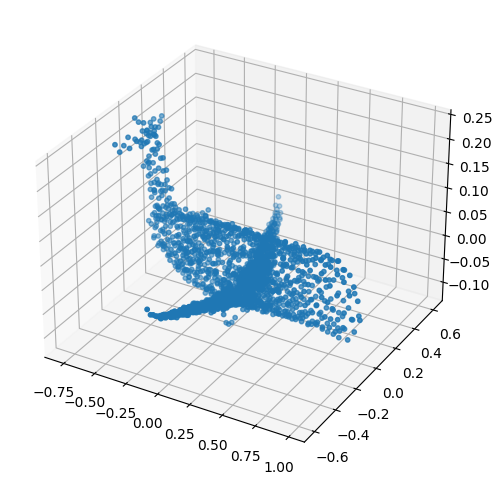

Validation sample reconstruction:


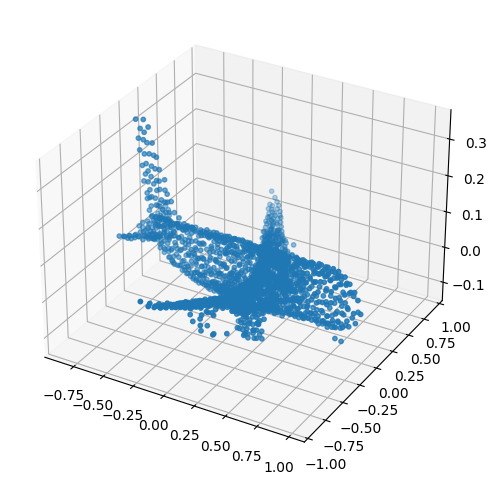

Early stopping, best epoch: 48 with loss: 0.03400981053709984


In [14]:
# Training loop
learning_rates = []
for epoch in range(saved_epoch, 101):
    model.train()
    train_loss = 0

    # Epoch training loop
    for batch in train_dataloader:
        # Calculate batch loss
        optimizer.zero_grad()
        output = model(batch)
        batch_loss = chamfer_distance(output, batch)

        # Accumulate loss over entire epoch
        train_loss += batch_loss

        # Backprop
        batch_loss.backward()
        optimizer.step()

    with torch.no_grad():
        train_loss /= len(train_dataloader)
        clear_output(wait=True)

        # Save learning rate history
        learning_rate = optimizer.param_groups[0]['lr']
        if learning_rate not in learning_rates:
            learning_rates.append(learning_rate)
        print(f"Learning rate history: {learning_rates}")

        print(f"Epoch {epoch} train_loss: {train_loss}")

        # Calculate validation loss
        model.eval()
        val_loss = 0
        for val_batch in val_dataloader:
            val_batch_output = model(val_batch)
            val_loss += chamfer_distance(val_batch_output, val_batch)

        val_loss /= len(val_dataloader)
        print(f"Epoch {epoch} val_loss: {val_loss}")

        # Update scheduler
        scheduler.step(val_loss)

        # Plot sample reconstructions
        train_sample_batch_output = model(train_sample_batch[0: 1])
        print("Train sample reconstruction:")
        plot_point_cloud(train_sample_batch_output[0].cpu())

        val_sample_batch_output = model(val_sample_batch)
        print("Validation sample reconstruction:")
        plot_point_cloud(val_sample_batch_output[0].cpu())

        # Check early stopping
        early_stopping(val_loss, model, epoch)
        saved_epoch = epoch + 1
        if early_stopping.early_stop:
            # Restore model to best state
            model.load_state_dict(early_stopping.best_state_dict)
            print(f"Early stopping, best epoch: {early_stopping.best_epoch} with loss: {early_stopping.val_loss_min}")
            break


In [15]:
# Save model and helper state
def save_state_dicts():
    state_dicts = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'early_stopping': early_stopping.get_state_dict(),
        'saved_epoch': saved_epoch
    }

    torch.save(state_dicts, STATE_DICTS_FILE)

save_state_dicts()


# Evaluation

Actual:


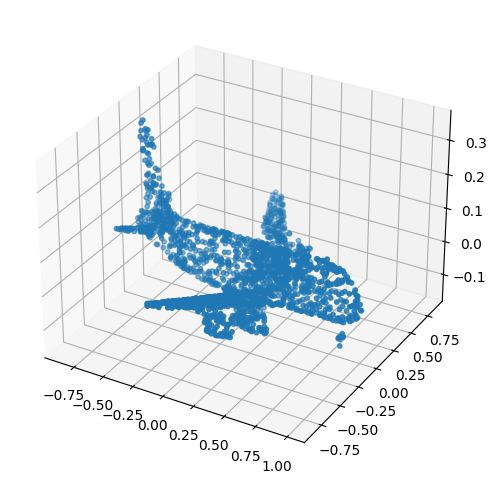

Reconstruction:


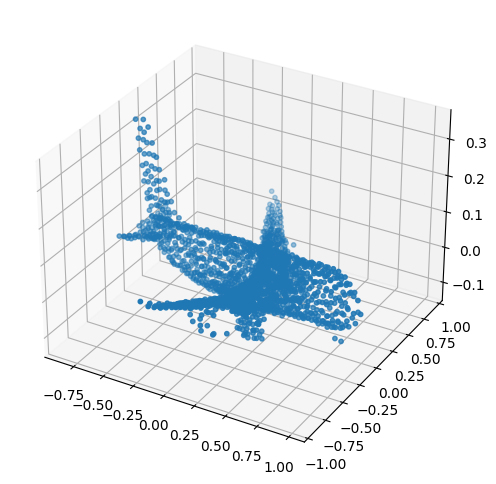

Actual:


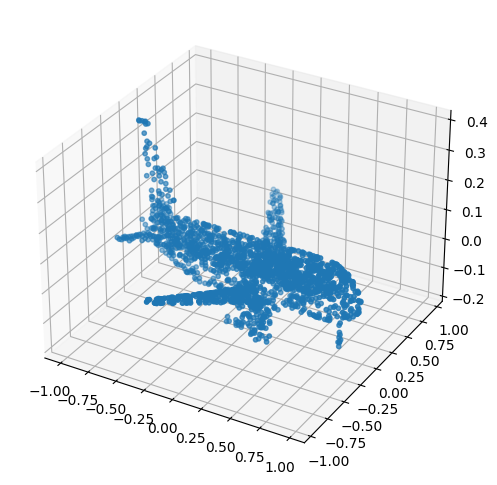

Reconstruction:


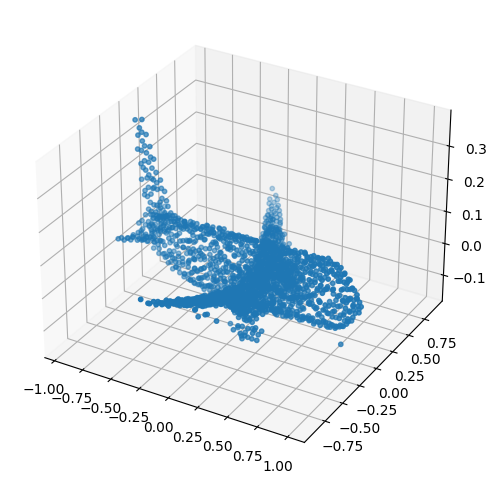

Actual:


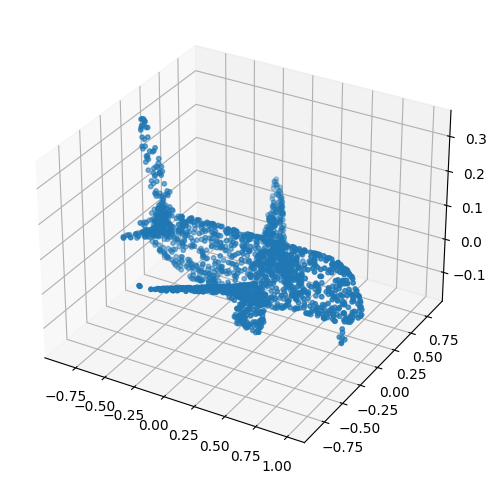

Reconstruction:


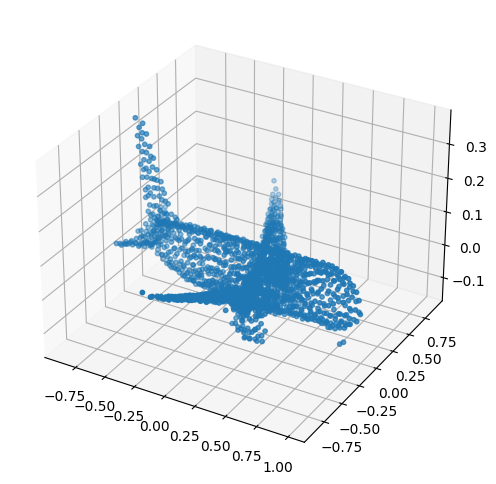

Actual:


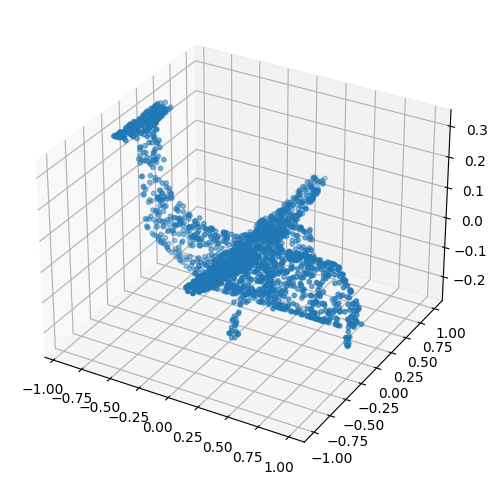

Reconstruction:


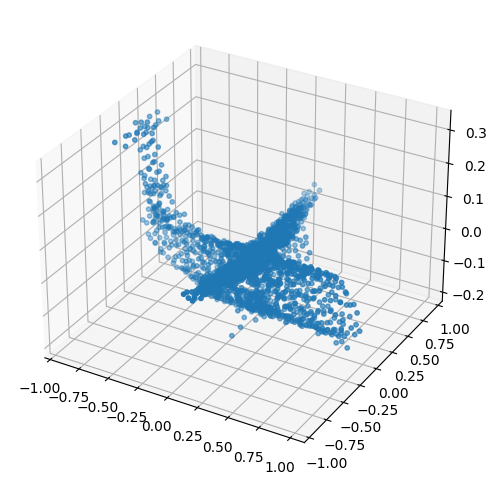

Actual:


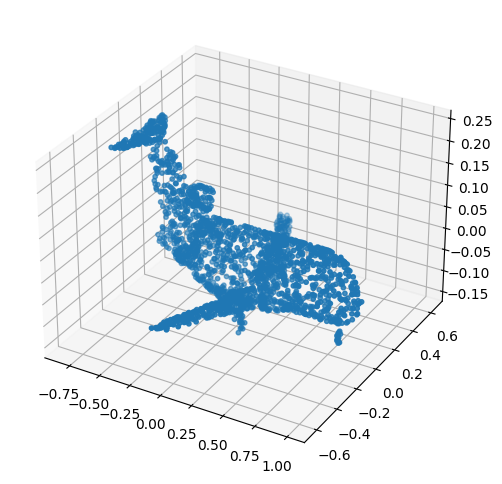

Reconstruction:


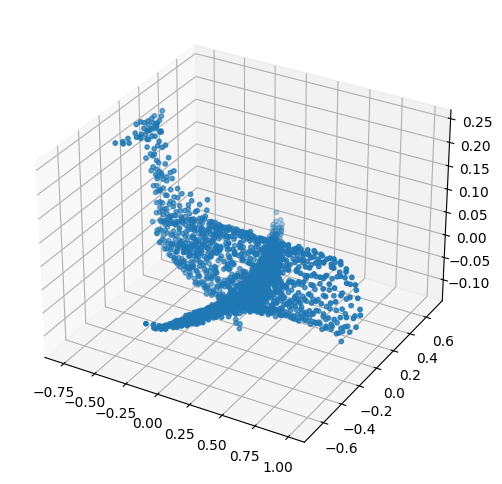

Actual:


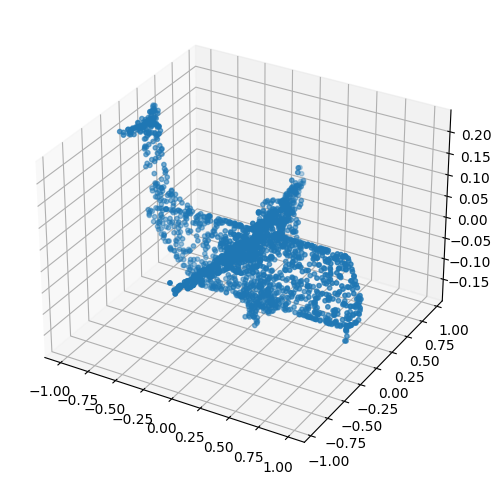

Reconstruction:


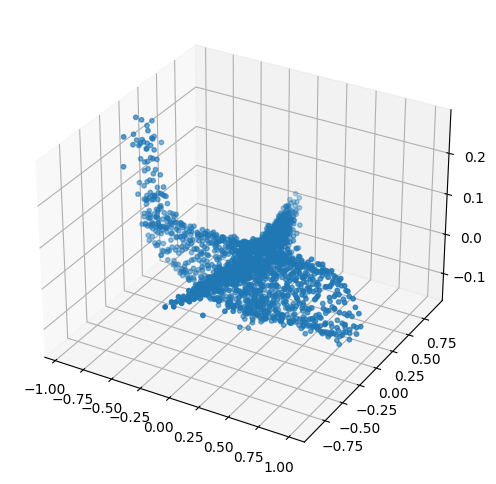

Actual:


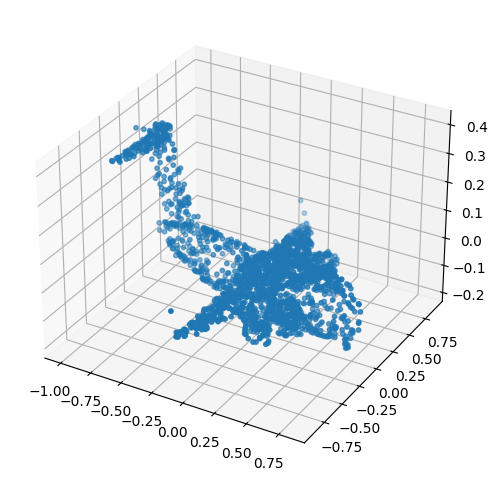

Reconstruction:


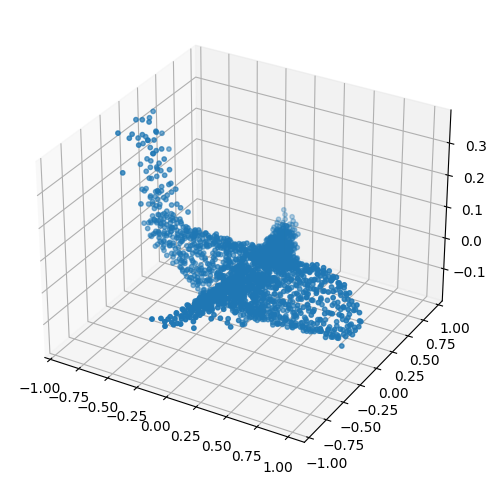

Actual:


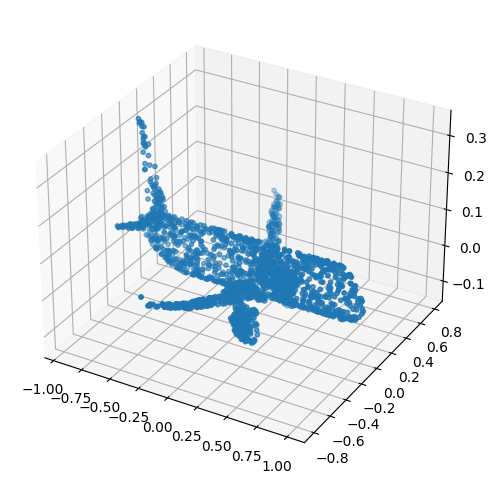

Reconstruction:


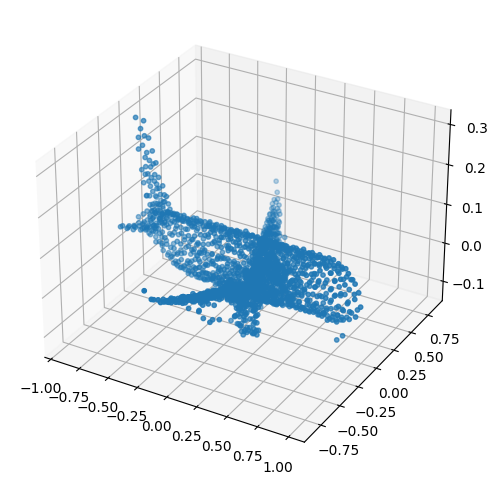

In [16]:
with torch.no_grad():
    model.eval()

    # Let's see how well the model reconstructs some of the validation samples
    comparison_sample_batch = val_sample_batch[0: 8]
    comparison_sample_batch_output = model(comparison_sample_batch)
    for comparison_sample, comparison_sample_output in zip(comparison_sample_batch, comparison_sample_batch_output):
        print("Actual:")
        plot_point_cloud(comparison_sample.cpu())
        print("Reconstruction:")
        plot_point_cloud(comparison_sample_output.cpu())


In [17]:
with torch.no_grad():
    model.eval()

    # Show latent vectors for some of the validation samples
    # to see their rough value ranges
    comparison_sample_latent_vectors = model.encoder(comparison_sample_batch.permute(0, 2, 1))
    print(comparison_sample_latent_vectors)

    # Generate new point clouds
    # This shouldn't really work with an ordinary autoencoder
    # because there is no constraint on the latent vector distribution
    # Let's try anyway
    random_latent_vectors = torch.rand((8, model.z_size)) * 8 - 4
    random_output = model.decoder(random_latent_vectors).permute(0, 2, 1)
    for random_output_sample in random_output:
        plot_point_cloud(random_output_sample.cpu())


AttributeError: 'PointNetEncoder' object has no attribute 'encoder'